In [2]:
import pandas as pd


df = pd.read_parquet("15min_data.parquet")
df = df.rename(columns={"Date": "Datetime"})
df = df.sort_values(["Ticker", "Datetime"])
print(df.head(50))

   Ticker            Datetime      Open      High       Low     Close   Volume
0    AAPL 2019-09-16 09:30:00  54.61750  54.69500  54.39003  54.59250  9712044
1    AAPL 2019-09-16 09:45:00  54.55000  54.95612  54.54250  54.92000  6860892
2    AAPL 2019-09-16 10:00:00  54.92800  54.93250  54.71973  54.74000  4395356
3    AAPL 2019-09-16 10:15:00  54.74000  54.82248  54.58625  54.59750  3583344
4    AAPL 2019-09-16 10:30:00  54.60000  54.74500  54.54750  54.71250  3211824
5    AAPL 2019-09-16 10:45:00  54.71750  54.74750  54.60750  54.72500  2391316
6    AAPL 2019-09-16 11:00:00  54.73125  54.91500  54.72000  54.90425  3380376
7    AAPL 2019-09-16 11:15:00  54.90500  55.02375  54.83000  54.97650  4166960
8    AAPL 2019-09-16 11:30:00  54.97500  55.00750  54.91750  54.99750  3311716
9    AAPL 2019-09-16 11:45:00  54.99750  55.03250  54.72500  54.76250  3973272
10   AAPL 2019-09-16 12:00:00  54.76000  54.83475  54.74500  54.80000  1804100
11   AAPL 2019-09-16 12:15:00  54.79750  54.85000  5

# Метрики

In [3]:
import numpy as np
from typing import Union

SeriesLike = Union[pd.Series, np.ndarray, list]


def _to_arrays(y_true: SeriesLike, y_pred: SeriesLike):
    y_true = pd.Series(y_true).astype(float)
    y_pred = pd.Series(y_pred).astype(float)
    df = pd.concat([y_true, y_pred], axis=1).dropna()
    return df.iloc[:, 0].to_numpy(), df.iloc[:, 1].to_numpy()


# Абосютные ошибки:

def mae(y_true: SeriesLike, y_pred: SeriesLike):
    y_true, y_pred = _to_arrays(y_true, y_pred)
    return np.mean(np.abs(y_true - y_pred))


def mse(y_true: SeriesLike, y_pred: SeriesLike):
    y_true, y_pred = _to_arrays(y_true, y_pred)
    return np.mean((y_true - y_pred) ** 2)


def rmse(y_true: SeriesLike, y_pred: SeriesLike):
    return np.sqrt(mse(y_true, y_pred))


def mdae(y_true: SeriesLike, y_pred: SeriesLike):
    y_true, y_pred = _to_arrays(y_true, y_pred)
    return np.median(np.abs(y_true - y_pred))


def mdse(y_true: SeriesLike, y_pred: SeriesLike):
    y_true, y_pred = _to_arrays(y_true, y_pred)
    return np.median((y_true - y_pred) ** 2)


# Относительные ошибки

def mape(y_true: SeriesLike, y_pred: SeriesLike):
    y_true, y_pred = _to_arrays(y_true, y_pred)
    if np.any(y_true == 0):
        raise ValueError("MAPE неопределён, y_true содержит нули")
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def smape(y_true: SeriesLike, y_pred: SeriesLike):
    y_true, y_pred = _to_arrays(y_true, y_pred)
    denom = (np.abs(y_true) + np.abs(y_pred))
    zero_mask = denom == 0
    denom[zero_mask] = np.nan
    return np.nanmean(np.abs(y_true - y_pred) / denom) * 200


def mspe(y_true: SeriesLike, y_pred: SeriesLike):
    y_true, y_pred = _to_arrays(y_true, y_pred)
    if np.any(y_true == 0):
        raise ValueError("MSPE неопределён, y_true содержит нули")
    return np.mean(((y_true - y_pred) / y_true) ** 2)


def rmspe(y_true: SeriesLike, y_pred: SeriesLike):
    return np.sqrt(mspe(y_true, y_pred))


# Взвешенные ошибки

def wape(y_true: SeriesLike, y_pred: SeriesLike):
    y_true, y_pred = _to_arrays(y_true, y_pred)
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))


# Масштабированные метрики

def mase(y_true: SeriesLike, y_pred: SeriesLike, seasonality: int = 1):
    """
    Mean Absolute Scaled Error from Hyndman.
    seasonality = 1 → naive differences (no seasonality)
    seasonality = m → seasonal naive benchmark
    """
    y_true, y_pred = _to_arrays(y_true, y_pred)
    y = pd.Series(y_true)

    if len(y) <= seasonality:
        raise ValueError("Ряд слишком короткий для заданной seasonality")

    scale = np.mean(np.abs(y[seasonality:].to_numpy() - y[:-seasonality].to_numpy()))
    if scale == 0:
        raise ValueError("Scaling factor равен 0; MASE неопределён")

    return np.mean(np.abs(y_true - y_pred)) / scale


def rmsse(y_true: SeriesLike, y_pred: SeriesLike, seasonality: int = 1):
    y_true, y_pred = _to_arrays(y_true, y_pred)
    y = pd.Series(y_true)

    if len(y) <= seasonality:
        raise ValueError("Ряд слишком короткий для заданной RMSSE seasonality")

    scale = np.mean((y[seasonality:].to_numpy() - y[:-seasonality].to_numpy()) ** 2)
    if scale == 0:
        raise ValueError("Scaling factor равен 0; MASE неопределён")

    return np.sqrt(np.mean((y_true - y_pred) ** 2) / scale)


# Относительные оишбки (относительно какой-то baseline-модели)

def rae(y_true: SeriesLike, y_pred: SeriesLike, y_baseline: SeriesLike):
    """Relative Absolute Error."""
    y_true, y_pred = _to_arrays(y_true, y_pred)
    y_true_b, y_base = _to_arrays(y_true, y_baseline)
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true_b - y_base))


def rse(y_true: SeriesLike, y_pred: SeriesLike, y_baseline: SeriesLike):
    """Relative Squared Error."""
    y_true, y_pred = _to_arrays(y_true, y_pred)
    y_true_b, y_base = _to_arrays(y_true, y_baseline)
    return np.sum((y_true - y_pred) ** 2) / np.sum((y_true_b - y_base) ** 2)


def rmae(y_true: SeriesLike, y_pred: SeriesLike, y_baseline: SeriesLike):
    return rae(y_true, y_pred, y_baseline)


def rrmse(y_true: SeriesLike, y_pred: SeriesLike, y_baseline: SeriesLike):
    return np.sqrt(rse(y_true, y_pred, y_baseline))


# Нормализованные метрики

def nrmse_std(y_true: SeriesLike, y_pred: SeriesLike):
    """Normalize RMSE by standard deviation of y_true."""
    y_true, y_pred = _to_arrays(y_true, y_pred)
    return rmse(y_true, y_pred) / np.std(y_true)


def nmae_range(y_true: SeriesLike, y_pred: SeriesLike):
    """Normalize MAE by value range."""
    y_true, y_pred = _to_arrays(y_true, y_pred)
    rng = np.max(y_true) - np.min(y_true)
    if rng == 0:
        raise ValueError("Range равен 0; NMAE неопределён")
    return mae(y_true, y_pred) / rng

# Прогнозы временных рядов с помощью классических методов

In [4]:
def prepare_data(df, ticker, target_col="target", datetime_col="Datetime"):
    """
    Фильтрует данные по тикеру, сортирует по времени и создаёт числовой временной индекс.
    """
    df = df[df["Ticker"] == ticker].copy()

    # Приведение к datetime и сортировка
    df[datetime_col] = pd.to_datetime(df[datetime_col])
    df = df.sort_values(datetime_col).reset_index(drop=True)

    # Порядковый индекс времени
    df["time_idx"] = np.arange(len(df))

    return df[[datetime_col, "time_idx", target_col]].reset_index(drop=True)

amzn = prepare_data(df, 'AMZN', target_col="Close")
amzn.tail()

Datetime  time_idx      Close
40070 2025-11-07 14:45:00     40070  243.55000
40071 2025-11-07 15:00:00     40071  243.71001
40072 2025-11-07 15:15:00     40072  243.37000
40073 2025-11-07 15:30:00     40073  244.78000
40074 2025-11-07 15:45:00     40074  244.41000

Посмотрим на стационарность:

In [5]:
from statsmodels.tsa.stattools import adfuller, kpss
import pandas as pd

def check_stationarity(
    df: pd.DataFrame,
    target_cols: list = None,
    alpha: float = 0.05
) -> pd.DataFrame:
    """
    Запускает два теста стационарности: ADF и KPSS.
    Возвращает те же поля, что и раньше, просто два теста подряд.
    """

    time_col = "Datetime" if "Datetime" in df.columns else "Date"
    df[time_col] = pd.to_datetime(df[time_col])

    # авто-поиск числовых колонок
    if not target_cols:
        exclude_cols = [time_col, "Ticker"]
        target_cols = [
            col for col in df.columns
            if col not in exclude_cols and pd.api.types.is_numeric_dtype(df[col])
        ]

    results = []

    for ticker, group in df.groupby("Ticker"):
        group = group.sort_values(time_col)

        for col in target_cols:
            series = group[col].dropna()

            if len(series) < 10:
                continue

            # --------------------
            # ADF
            # --------------------
            adf_stat, adf_p, _, _, _, _ = adfuller(series)
            adf_stationary = int(adf_p < alpha)  # H0: нестационарен

            results.append({
                "Ticker": ticker,
                "Feature": col,
                "Test": "ADF",
                "TestStatistic": adf_stat,
                "PValue": adf_p,
                "IsStationary": adf_stationary
            })

            # --------------------
            # KPSS
            # --------------------
            kpss_stat, kpss_p, _, _ = kpss(series, regression="c", nlags="auto")
            kpss_stationary = int(kpss_p > alpha)  # H0: стационарен

            results.append({
                "Ticker": ticker,
                "Feature": col,
                "Test": "KPSS",
                "TestStatistic": kpss_stat,
                "PValue": kpss_p,
                "IsStationary": kpss_stationary
            })

    return pd.DataFrame(results)


stationarity_results = check_stationarity(df[df['Ticker'] == 'AMZN'])

/tmp/ipython-input-59818751.py:54: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_p, _, _ = kpss(series, regression="c", nlags="auto")
/tmp/ipython-input-59818751.py:54: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_p, _, _ = kpss(series, regression="c", nlags="auto")
/tmp/ipython-input-59818751.py:54: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_p, _, _ = kpss(series, regression="c", nlags="auto")
/tmp/ipython-input-59818751.py:54: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than th

In [6]:
stationarity_results

Ticker Feature  Test  TestStatistic        PValue  IsStationary
0   AMZN    Open   ADF      -1.183085  6.808295e-01             0
1   AMZN    Open  KPSS      13.417951  1.000000e-02             0
2   AMZN    High   ADF      -1.111627  7.104129e-01             0
3   AMZN    High  KPSS      13.431592  1.000000e-02             0
4   AMZN     Low   ADF      -1.138677  6.994042e-01             0
5   AMZN     Low  KPSS      13.410724  1.000000e-02             0
6   AMZN   Close   ADF      -1.197729  6.745718e-01             0
7   AMZN   Close  KPSS      13.420539  1.000000e-02             0
8   AMZN  Volume   ADF     -14.111964  2.510668e-26             1
9   AMZN  Volume  KPSS       9.576257  1.000000e-02             0

In [7]:
amzn["Close_diff"] = amzn["Close"].diff().fillna(0)

from statsmodels.tsa.stattools import adfuller

adf_stat, adf_p, _, _, _, _ = adfuller(amzn["Close_diff"].dropna())

print("ADF statistic:", adf_stat)
print("ADF p-value:", adf_p)
if adf_p < 0.05:
  print('Ряд стационарен')

ADF statistic: -36.5598910353316
ADF p-value: 0.0
Ряд стационарен


### Простые прогнозы на основе классических методов:

In [8]:
def naive_forecast(series, horizon):
    # Наивный метод y^​t+1​=yt​
    last_value = series.iloc[-1]
    return np.repeat(last_value, horizon)


def seasonal_naive_forecast(series, horizon, season_length=7):
    """
    season_length = 26 - дневная сезонность
    """
    values = series.iloc[-season_length:]
    repeats = horizon // season_length + 1
    return np.tile(values, repeats)[:horizon]


def moving_average_forecast(series, horizon, window=26, mode="shift"):
    """
    Реально рекурсивный вариант Moving Average:
    mode = "shift"     → фиксированное окно
    mode = "expanding" → растущее окно
    """

    history = list(series)
    forecasts = []

    for i in range(horizon):

        if mode == "shift":
            current_window = window

        elif mode == "expanding":
            current_window = window + i

        else:
            raise ValueError("mode должен быть 'shift' или 'expanding'.")

        # ограничиваем окно длиной истории
        current_window = min(current_window, len(history))

        # среднее по окну
        ma = np.mean(history[-current_window:])

        # записываем прогноз
        forecasts.append(ma)

        # рекурсивность: добавляем прогноз в историю
        history.append(ma)

    return np.array(forecasts)



def drift_forecast(series, horizon, lookback=None):
    """
    lookback: если None - используем всю выборку, иначе используем последние lookback точек
    """
    if lookback is not None:
        series = series.iloc[-lookback:]

    y1 = series.iloc[0]
    y_last = series.iloc[-1]
    n = len(series)

    drift = (y_last - y1) / (n - 1)
    return y_last + drift * np.arange(1, horizon + 1)


from statsmodels.tsa.holtwinters import ExponentialSmoothing


def exponential_smoothing_forecast(
    series,
    horizon,
    trend=None,            # None, 'add', 'mul'
    damped=False,          # демпфирование тренда
    seasonal=None,         # None, 'add', 'mul'
    seasonal_periods=None, # период сезонности
    use_boxcox=False,      # Box-Cox преобразование
    initialization_method="estimated",  # 'estimated' или 'heuristic'
    optimized=True,        # авто-поиск параметров
    smoothing_level=None,  # α
    smoothing_slope=None,  # β
    smoothing_seasonal=None, # γ
    damping_slope=None      # φ
):

    model = ExponentialSmoothing(
        series,
        trend=trend, # 'add', 'mul' или None
        damped_trend=damped, # True / False
        seasonal=seasonal, # 'add', 'mul' или None
        seasonal_periods=seasonal_periods,
        initialization_method=initialization_method,
        use_boxcox=use_boxcox,
    )

    fitted = model.fit(
        optimized=optimized,
        smoothing_level=smoothing_level,
        smoothing_slope=smoothing_slope,
        smoothing_seasonal=smoothing_seasonal,
        damping_slope=damping_slope,
    )

    forecast = fitted.forecast(horizon)
    return forecast, fitted

In [ ]:
pip install prophet

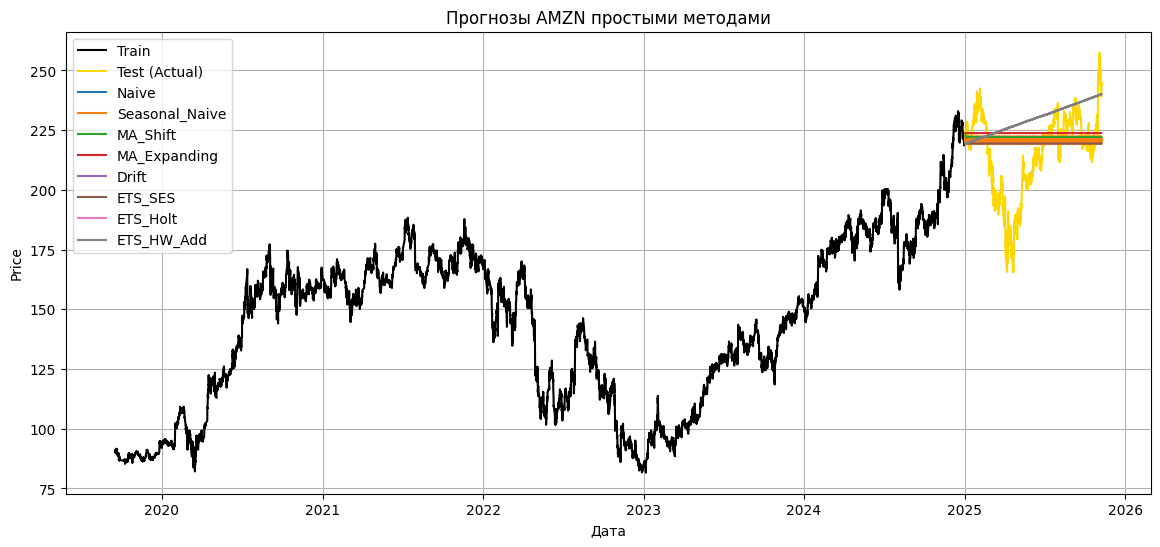

In [9]:
import matplotlib.pyplot as plt


def train_test_split_by_date(df, date_col="Datetime", split_date="2025-01-01"):
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])

    train = df[df[date_col] < split_date]
    test  = df[df[date_col] >= split_date]

    return train, test


# Делаем split
train, test = train_test_split_by_date(amzn, "Datetime", "2025-01-01")

y_train = train["Close"]
horizon = len(test)

# Запуск всех методов
preds = pd.DataFrame({
    "Datetime": test["Datetime"].values,
    "Actual": test["Close"].values
})

# 1. Naive
preds["Naive"] = naive_forecast(y_train, horizon)

# 2. Seasonal Naive
preds["Seasonal_Naive"] = seasonal_naive_forecast(y_train, horizon, season_length=26)

# 3. Moving Average (shift)
preds["MA_Shift"] = moving_average_forecast(y_train, horizon, window=120, mode="shift")

# 4. Moving Average (expanding)
preds["MA_Expanding"] = moving_average_forecast(y_train, horizon, window=120, mode="expanding")

# 5. Drift
preds["Drift"] = drift_forecast(y_train, horizon)

# 6. ETS Models

# SES (ETS(A,N,N))
preds["ETS_SES"] = exponential_smoothing_forecast(
    y_train, horizon, trend=None, seasonal=None
)[0].values

# Holt (ETS(A,A,N))
preds["ETS_Holt"] = exponential_smoothing_forecast(
    y_train, horizon, trend="add", seasonal=None
)[0].values

# Holt-Winters ADDITIVE (ETS(A,A,A))
preds["ETS_HW_Add"] = exponential_smoothing_forecast(
    y_train, horizon,
    trend="add",
    seasonal="add",
    seasonal_periods=26
)[0].values


# Визуализация

plt.figure(figsize=(14, 6))
plt.plot(train["Datetime"], y_train, label="Train", color="black")
plt.plot(test["Datetime"], test["Close"], label="Test (Actual)", color="gold")

for col in preds.columns:
    if col not in ("Datetime", "Actual"):
        plt.plot(preds["Datetime"], preds[col], label=col)

plt.title("Прогнозы AMZN простыми методами")
plt.xlabel("Дата")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


naive_methods = preds.copy()  # Сохраним для дальнейшего анализа

In [10]:
import plotly.graph_objects as go

def plot_forecasts_interactive(train, test, preds, target_col="Close"):
    """
    train — DataFrame с тренингом (Datetime, Close)
    test — DataFrame с тестом
    preds — DataFrame: Datetime, Actual, Model1, Model2, ...
    """

    fig = go.Figure()


    fig.add_trace(go.Scatter(
        x=train["Datetime"],
        y=train[target_col],
        mode="lines",
        name="Train",
        line=dict(color="black", width=2)
    ))

    fig.add_trace(go.Scatter(
        x=test["Datetime"],
        y=test[target_col],
        mode="lines",
        name="Test (Actual)",
        line=dict(color="gold", width=3)
    ))

    # Прогнозы
    for col in preds.columns:
        if col in ("Datetime", "Actual"):
            continue

        fig.add_trace(go.Scatter(
            x=preds["Datetime"],
            y=preds[col],
            mode="lines",
            name=col,
            line=dict(width=2),
            visible="legendonly"   # скрыты по умолчанию
        ))

    fig.update_layout(
        title="Прогнозы Close AMZN на 2025 год — интерактивная визуализация",
        xaxis_title="Дата",
        yaxis_title="Цена",
        width=1200,
        height=600,
        template="plotly_white",
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        )
    )

    fig.show()


plot_forecasts_interactive(train, test, preds, target_col="Close")

In [11]:
naive_methods.head()

Datetime     Actual   Naive  Seasonal_Naive    MA_Shift  \
0 2025-01-02 09:30:00  221.13000  219.39       221.24001  223.755195   
1 2025-01-02 09:45:00  224.02499  219.39       222.27499  223.725030   
2 2025-01-02 10:00:00  224.86000  219.39       221.65010  223.686072   
3 2025-01-02 10:15:00  223.25391  219.39       221.39951  223.651748   
4 2025-01-02 10:30:00  222.10001  219.39       221.23000  223.615684   

   MA_Expanding       Drift     ETS_SES    ETS_Holt  ETS_HW_Add  
0    223.755195  219.393729  219.401396  219.405223  219.417123  
1    223.755195  219.397458  219.401396  219.408953  219.425672  
2    223.755195  219.401188  219.401396  219.412683  219.405638  
3    223.755195  219.404917  219.401396  219.416412  219.404754  
4    223.755195  219.408646  219.401396  219.420142  219.415490

## **ARIMA-семейство** (AR, MA, ARMA работают только со стационарными рядами):

In [12]:
import numpy as np
import pandas as pd
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


def fit_ar(series, lags=1, steps=10):
    """
    AR(p) модель.
    series — временной ряд (pd.Series)
    lags — порядок AR(p)
    steps — горизонт прогноза
    """
    model = AutoReg(series, lags=lags).fit()
    forecast = model.predict(start=len(series), end=len(series) + steps - 1)
    return model, forecast


def fit_ma(series, q=1, steps=10):
    """
    MA(q) модель через ARIMA(p=0, d=0, q=q)
    """
    model = ARIMA(series, order=(0, 0, q)).fit()
    forecast = model.forecast(steps=steps)
    return model, forecast


def fit_arma(series, p=1, q=1, steps=10):
    """
    ARMA(p, q) модель через ARIMA(p,0,q)
    """
    model = ARIMA(series, order=(p, 0, q)).fit()
    forecast = model.forecast(steps=steps)
    return model, forecast


def fit_arima(series, p=1, d=1, q=1, steps=10):
    """
    ARIMA(p, d, q) модель.
    """
    model = ARIMA(series, order=(p, d, q)).fit()
    forecast = model.forecast(steps=steps)
    return model, forecast


def fit_sarima(series, p=1, d=1, q=1, P=1, D=1, Q=1, s=12, steps=10):
    """
    SARIMA(p,d,q) × (P,D,Q)s модель.
    s — длина сезонности (например, 12 для месяцев)
    """
    model = SARIMAX(
        series,
        order=(p, d, q),
        seasonal_order=(P, D, Q, s),
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit()

    forecast = model.forecast(steps=steps)
    return model, forecast

In [ ]:
!pip install pmdarima

Подбираем ARIMA параметры...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=61749.156, Time=10.75 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=61743.985, Time=4.40 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=61743.793, Time=2.26 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=61743.785, Time=4.81 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=61743.356, Time=0.65 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=61745.758, Time=6.40 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 29.277 seconds
Найденные параметры ARIMA: (0, 1, 0)


Fitting models: 100%|██████████| 5/5 [03:19<00:00, 39.80s/it]


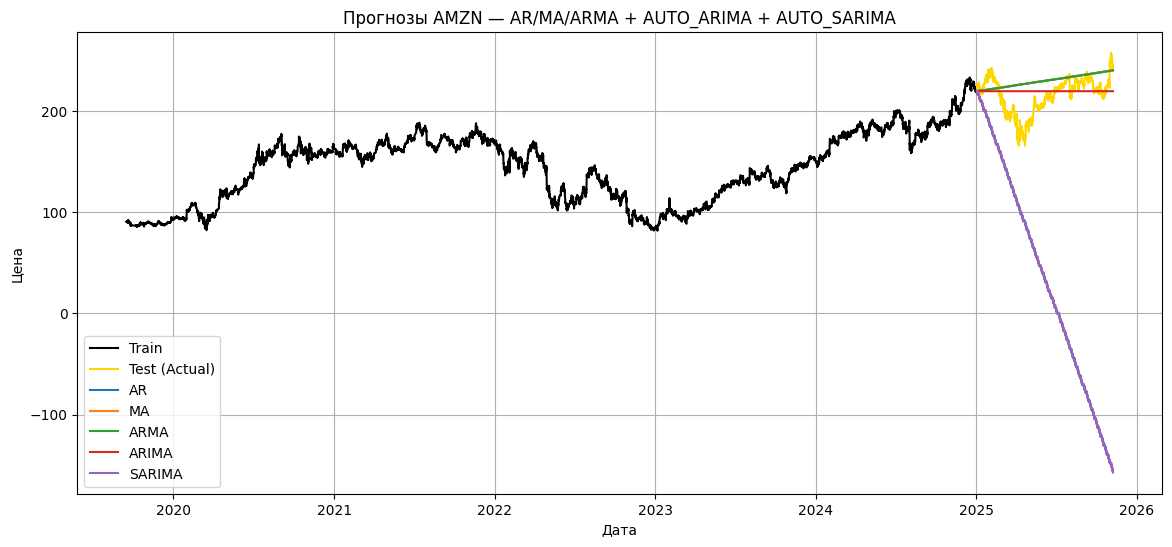

In [13]:
import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
from pmdarima import auto_arima


# ======================
# 0. Разности + Split
# ======================

amzn["Close_diff"] = amzn["Close"].diff()
amzn["Close_diff"] = amzn["Close_diff"].fillna(0)

train, test = train_test_split_by_date(amzn, "Datetime", "2025-01-01")

y_train = train["Close"]
y_train_diff = train["Close_diff"]
horizon = len(test)

preds = pd.DataFrame({
    "Datetime": test["Datetime"].values,
    "Actual": test["Close"].values
})


# ======================
# 1. AUTO ARIMA (параметры для ARIMA)
# ======================

print("Подбираем ARIMA параметры...")
auto_arima_model = auto_arima(
    y_train,
    seasonal=False,
    d=1,
    max_p=5,
    max_q=5,
    stepwise=True,
    trace=True,
    suppress_warnings=True
)

p_arima, d_arima, q_arima = auto_arima_model.order
print("Найденные параметры ARIMA:", (p_arima, d_arima, q_arima))


# ======================
# 2. AUTO SARIMA (параметры для SARIMA)
# ======================

# print("\nПодбираем SARIMA параметры...")
# auto_sarima_model = auto_arima(
#     y_train,
#     seasonal=True,
#     m=26,
#     start_P=0, start_Q=0,
#     max_P=1, max_Q=1,
#     d=1, D=1,
#     stepwise=True,
#     trace=True
# )

# p_s, d_s, q_s = auto_sarima_model.order
# P_s, D_s, Q_s, m_s = auto_sarima_model.seasonal_order
# print("Найденные параметры SARIMA:", (p_s, d_s, q_s, P_s, D_s, Q_s, m_s))


# ======================
# Список моделей для прогонки
# ======================

tasks = [
    ("AR",      lambda: fit_ar(y_train_diff, lags=1, steps=horizon)),
    ("MA",      lambda: fit_ma(y_train_diff, q=1, steps=horizon)),
    ("ARMA",    lambda: fit_arma(y_train_diff, p=1, q=1, steps=horizon)),

    # ARIMA с заранее найденными параметрами
    ("ARIMA",   lambda: fit_arima(y_train, p_arima, d_arima, q_arima, steps=horizon)),

    # Вставляем фиксированную SARIMA: ARIMA(2,1,2)(0,1,0)[26]
    ("SARIMA",  lambda: fit_sarima(
        y_train,
        # y_train[-2000:],
        p=2, d=1, q=2,
        P=0, D=1, Q=0,
        s=26,
        steps=horizon
    ))
]


# ======================
# Запуск с tqdm
# ======================

for name, fn in tqdm(tasks, desc="Fitting models"):
    model, forecast = fn()

    # Для AR, MA, ARMA нужно восстановить уровень
    if name in ("AR", "MA", "ARMA"):
        preds[name] = y_train.iloc[-1] + forecast.cumsum().values
    else:
        preds[name] = forecast.values


# ======================
# Визуализация
# ======================

plt.figure(figsize=(14, 6))
plt.plot(train["Datetime"], y_train, label="Train", color="black")
plt.plot(test["Datetime"], test["Close"], label="Test (Actual)", color="gold")

for col in preds.columns:
    if col not in ("Datetime", "Actual"):
        plt.plot(preds["Datetime"], preds[col], label=col)

plt.title("Прогнозы AMZN — AR/MA/ARMA + AUTO_ARIMA + AUTO_SARIMA")
plt.xlabel("Дата")
plt.ylabel("Цена")
plt.legend()
plt.grid(True)
plt.show()

Это дракончик ⏫

In [18]:
plot_forecasts_interactive(train, test, preds, target_col="Close")

In [16]:
naive_methods = naive_methods.drop(columns=["Actual"])

# объединяем
merged = naive_methods.merge(preds, on="Datetime", how="inner")
merged.head()

Datetime   Naive  Seasonal_Naive    MA_Shift  MA_Expanding  \
0 2025-01-02 09:30:00  219.39       221.24001  223.755195    223.755195   
1 2025-01-02 09:45:00  219.39       222.27499  223.725030    223.755195   
2 2025-01-02 10:00:00  219.39       221.65010  223.686072    223.755195   
3 2025-01-02 10:15:00  219.39       221.39951  223.651748    223.755195   
4 2025-01-02 10:30:00  219.39       221.23000  223.615684    223.755195   

        Drift     ETS_SES    ETS_Holt  ETS_HW_Add     Actual          AR  \
0  219.393729  219.401396  219.405223  219.417123  221.13000  219.405154   
1  219.397458  219.401396  219.408953  219.425672  224.02499  219.408793   
2  219.401188  219.401396  219.412683  219.405638  224.86000  219.412523   
3  219.404917  219.401396  219.416412  219.404754  223.25391  219.416252   
4  219.408646  219.401396  219.420142  219.415490  222.10001  219.419982   

           MA        ARMA   ARIMA      SARIMA  
0  219.405197  219.405314  219.39  219.521367  
1  219.408923  219.409458  219.39  220.461928  
2  219.412648  219.413201  219.39  219.929722  
3  219.416374  219.416930  219.39  219.591220  
4  219.420099  219.420658  219.39  219.506982

In [17]:
def evaluate_all_models(merged, target="Actual", baseline="Naive"):
    models = [col for col in merged.columns if col not in ("Datetime", target)]

    results = []

    for model in models:
        y_true = merged[target]
        y_pred = merged[model]
        y_base = merged[baseline]

        row = {
            "Model": model,

            # Асболютные ошибки
            "MAE": mae(y_true, y_pred),
            "MSE": mse(y_true, y_pred),
            "RMSE": rmse(y_true, y_pred),
            "MDAE": mdae(y_true, y_pred),
            "MDSE": mdse(y_true, y_pred),

            # Относительные ошибки
            "MAPE": mape(y_true, y_pred),
            "sMAPE": smape(y_true, y_pred),
            "MSPE": mspe(y_true, y_pred),
            "RMSPE": rmspe(y_true, y_pred),

            # Взвешанные
            "WAPE": wape(y_true, y_pred),

            # Нормализованные метрики
            "MASE": mase(y_true, y_pred, seasonality=1),
            "RMSSE": rmsse(y_true, y_pred, seasonality=1),

            # Относительно baseline (Naive)
            "RAE": rae(y_true, y_pred, y_base),
            "RSE": rse(y_true, y_pred, y_base),
            "RMAE": rmae(y_true, y_pred, y_base),
            "RRMSE": rrmse(y_true, y_pred, y_base),

            # Normalized
            "NRMSE_STD": nrmse_std(y_true, y_pred),
            "NMAE_RANGE": nmae_range(y_true, y_pred)
        }

        results.append(row)

    return pd.DataFrame(results)


metrics_df = evaluate_all_models(merged, target="Actual", baseline="Naive")
metrics_df

Model         MAE           MSE        RMSE        MDAE  \
0            Naive   13.552107    320.057148   17.890141   10.656195   
1   Seasonal_Naive   13.565669    332.701135   18.240097   10.059990   
2         MA_Shift   13.709236    349.001622   18.681585    9.427322   
3     MA_Expanding   14.080609    373.445891   19.324748    9.155140   
4            Drift   17.382451    472.430135   21.735458   14.926895   
5          ETS_SES   13.551634    320.146913   17.892650   10.644799   
6         ETS_Holt   17.390585    472.786036   21.743644   14.934890   
7       ETS_HW_Add   17.409393    473.459745   21.759130   14.960161   
8               AR   17.390444    472.780077   21.743507   14.934871   
9               MA   17.381498    472.464768   21.736255   14.927687   
10            ARMA   17.388255    472.706814   21.741822   14.933576   
11           ARIMA   13.552107    320.057148   17.890141   10.656195   
12          SARIMA  183.975602  47288.188398  217.458475  181.353257   

            MDSE       MAPE       sMAPE      MSPE     RMSPE      WAPE  \
0     113.554530   6.656649    6.387286  0.008593  0.092699  0.062899   
1     101.203399   6.703213    6.392597  0.009054  0.095155  0.062962   
2      88.874406   6.810565    6.456484  0.009604  0.098002  0.063629   
3      83.816588   7.027773    6.621761  0.010367  0.101817  0.065352   
4     222.812193   8.609336    8.059114  0.012857  0.113390  0.080677   
5     113.311781   6.656779    6.387064  0.008597  0.092718  0.062897   
6     223.050955   8.613300    8.062599  0.012866  0.113431  0.080715   
7     223.806427   8.622159    8.070655  0.012883  0.113503  0.080802   
8     223.050374   8.613231    8.062539  0.012866  0.113430  0.080714   
9     222.835829   8.609027    8.058706  0.012859  0.113396  0.080673   
10    223.011701   8.612211    8.061601  0.012865  0.113422  0.080704   
11    113.554530   6.656649    6.387286  0.008593  0.092699  0.062899   
12  32889.005817  83.774075  125.507099  0.947383  0.973336  0.853884   

          MASE       RMSSE        RAE         RSE       RMAE      RRMSE  \
0    27.099428   18.491737   1.000000    1.000000   1.000000   1.000000   
1    27.126548   18.853460   1.001001    1.039505   1.001001   1.019561   
2    27.413630   19.309795   1.011594    1.090435   1.011594   1.044239   
3    28.156245   19.974585   1.038998    1.166810   1.038998   1.080190   
4    34.758763   22.466361   1.282638    1.476081   1.282638   1.214941   
5    27.098482   18.494330   0.999965    1.000280   0.999965   1.000140   
6    34.775029   22.474822   1.283238    1.477193   1.283238   1.215398   
7    34.812637   22.490829   1.284626    1.479298   1.284626   1.216264   
8    34.774745   22.474680   1.283228    1.477174   1.283228   1.215390   
9    34.756857   22.467184   1.282568    1.476189   1.282568   1.214985   
10   34.770370   22.472939   1.283067    1.476945   1.283067   1.215296   
11   27.099428   18.491737   1.000000    1.000000   1.000000   1.000000   
12  367.886230  224.770996  13.575424  147.749202  13.575424  12.155213   

    NRMSE_STD  NMAE_RANGE  
0    1.025074    0.147306  
1    1.045126    0.147453  
2    1.070422    0.149013  
3    1.107274    0.153050  
4    1.245404    0.188940  
5    1.025217    0.147300  
6    1.245873    0.189028  
7    1.246760    0.189233  
8    1.245865    0.189027  
9    1.245449    0.188929  
10   1.245768    0.189003  
11   1.025074    0.147306  
12  12.459989    1.999735

На данном этапе задачей было попробовать использовать классические существующие методы прогнозирования временных рядов, посмотреть на метрики качества (+ реализовать их) на примере акций Амазона с прогнозом цены закрытия на 2025 год. Проведенное исследование позволяет сделать некоторые выводы:


*   Сложные модели (ARIMA, SARIMA) обучаются достаточно долго даже на одном временном ряду, а в проде мы хотим прогнозировать 6 параметров для 10 акций -> необходимо либо ограничивать длину тренировочных данных, либо не использовать auto подбор параметров (который в нашем случае рассчитал оптимальные параметры, приведя ARIMA в наивный прогноз)
*   Наивный прогноз является одним из наиболее лучшим по метрикам, кажется для прод-решения надо ограничивать длину горизонта планирования до более адекватного (например, 4 дня - 104 интервала по 15 минут), либо использовать более сложные модели с возможностью включения других признаков
*   Получилось реализовать почти все метрики из статьи https://arxiv.org/pdf/2203.10716, отдельно отметим метрики качества относительно baselin'a, что поможет сравнивать модели между собой. В прод решении хотим предлагать пользователю оценку модели по наиболее подходящим для временного ряда метрикам. В качестве основной метрики на данном этапе предлагаем смотреть на RMSE для такого же масштаба данных
*   На данном этапе не рассматривались сложные ML-модели (исходя из плана годового проекта), будем добавлять такие модели и улучшать их постепенно к следующим чекпойнтам


Дальнейшей целью является создание прототипа системы и создание MPV решения через FAST-API
